# Kohli in the Clutch: A Data-Driven Analysis

1. Introduction
2. Methodology
3. Summary of Dataset
4. Insights
5. Final Thoughts

In [1]:
# Basic Setup
import sys
import os
sys.path.append(os.path.abspath(".."))

import warnings
warnings.filterwarnings('ignore')

## 1. Introduction

In cricket, not all runs are created equal. A calm fifty in a one-sided bilateral series feels very different from a gritty 35 in a World Cup semi-final chase. As fans, we often talk about a player’s ability to perform "under pressure"—to rise when the stakes are highest. This quality is what people refer to as *clutch*.

Virat Kohli is often seen as that kind of player. Whether it's facing Pakistan in a packed stadium or chasing a tough target in a World Cup match, he's known for showing up when it matters. But instead of just relying on memory or emotion, I wanted to explore this idea through data. Can we **measure** clutch performance? And if so, does the data support the belief that Kohli is India’s ultimate big-match player?

**What is “clutch performance” in cricket?**
In simple terms, clutch performance means delivering under pressure. It includes factors like:

* Playing in knockouts or finals
* Facing strong opponents
* Chasing big totals
* Coming in early after quick wickets

These are moments where context matters more than just raw stats. For example, a 35 against Sri Lanka in a World Cup final might be far more impactful than a century in a low-stakes match.

That’s why I built this project: to go beyond the surface-level numbers and ask a more interesting question — **how well has Kohli actually performed in clutch situations, based on data?**

## 2. Summary of Dataset

Our dataset consists of **10 handpicked international matches** played by India, each featuring Virat Kohli in a prominent batting role. These matches span various formats and contexts, with a focus on analyzing his performance under pressure.

### Matches Analyzed

* **Total Matches**: 10
* **Clutch-Labeled Matches**: 5 (e.g., World Cup 2022 vs Pakistan, World Cup Final 2023 vs Australia)
* **Normal Matches**: 5 (e.g., bilateral series vs Sri Lanka, Australia)

These were chosen based on a mix of **high-stakes encounters** and **regular bilateral games**, giving us a baseline to compare performances across different match pressures.

### Cleaned Columns & Format

The dataset includes columns such as match date, opposition, match type, innings context, Kohli’s individual performance (runs, balls, dismissal), and match outcomes. All missing values were handled, and data types were standardized.

* Full details of each column are documented in [`data/dataset_schema.md`](../data/dataset_schema.md).
* The sources used to compile this dataset are listed in [`data/raw/data_source.md`](../data/raw/data_source.md).

### Match Contexts Captured

* **Stages**: Group stage, semi-finals, finals, bilateral matches
* **Oppositions**: A mix of top cricketing nations including Australia, Pakistan, New Zealand, and South Africa
* **Results**: Balanced distribution with both wins and losses, giving us varied outcome-based pressure situations

This cleaned dataset provides the foundation for computing a **Clutch Score**, comparing pressure performance, and uncovering patterns in Kohli’s contributions.

In [2]:
# Data Preview
from src.data_loader import load_cleaned_data

# Load cleaned data
df = load_cleaned_data("../data/processed/processed_data.csv")

# Show preview
df.head()

,match_id,date,opposition,match_type,match_stage,venue,toss_win,match_winner,target_score,is_chasing,arrival_time,runs_scored,balls_faced,dismissal,dismissal_time,result,clutch_label,player_of_the_match,run_bracket
0,INDvPAK_WC2022,2022-10-23,Pakistan,T20,Group,Melbourne,India,India,160,True,7/1,82,53,Not Out,-1,India Win,Clutch,Virat Kohli,80+
1,INDvAUS_WC2016,2016-03-27,Australia,T20,Group,Mohali,Australia,India,161,True,23/1,82,51,Not Out,-1,India Win,Clutch,Virat Kohli,80+
2,INDvNZ_WC2019,2019-07-09,New Zealand,ODI,Semi-Final,Manchester,New Zealand,New Zealand,240,True,4/1,1,6,LBW,5/2,India Lost,Clutch,Matt Henry,<10
3,INDvAUS_WC2023,2023-11-19,Australia,ODI,Final,Ahmedabad,Australia,Australia,241,False,30/1,54,63,Bowled,148/4,India Lost,Clutch,Travis Head,50–79
4,INDvPAK_CT2017,2017-06-19,Pakistan,ODI,Final,London,India,Pakistan,339,True,0/1,5,9,Caught,6/2,India Lost,Clutch,Fakhar Zaman,<10


In [3]:
# See column types, memory usage, and nulls (if any)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   match_id             10 non-null     object
 1   date                 10 non-null     object
 2   opposition           10 non-null     object
 3   match_type           10 non-null     object
 4   match_stage          10 non-null     object
 5   venue                10 non-null     object
 6   toss_win             10 non-null     object
 7   match_winner         10 non-null     object
 8   target_score         10 non-null     int64 
 9   is_chasing           10 non-null     bool  
 10  arrival_time         10 non-null     object
 11  runs_scored          10 non-null     int64 
 12  balls_faced          10 non-null     int64 
 13  dismissal            10 non-null     object
 14  dismissal_time       10 non-null     object
 15  result               10 non-null     object
 16  clutch_labe

## 3. Methodology

**But how do we calculate Clutch Score?**

Measuring clutch performance isn't straightforward, because pressure depends on many factors—not just how many runs a player scores. So, I designed a custom scoring system called the **Clutch Score**, which considers both *match context* and *individual performance*.

The final clutch score is a sum of two components:

1. **Context Score** – How high-pressure was the match situation?
2. **Performance Score** – How well did Kohli perform in that context?

**Context Score Criteria:**
Each match is rated based on pressure indicators:

* **Match Stage**: Finals and knockouts score higher than group or bilateral games
* **Opposition Strength**: Traditional rivals like Pakistan or strong teams like Australia carry more weight
* **Target Score**: Higher run chases in ODIs/T20s add pressure
* **Arrival Time**: Early wickets = more pressure on the incoming batter
* **Chasing or Batting First**: Chasing is generally considered more tense
* **Match Result**: Win or loss contributes to understanding pressure outcome

**Performance Score Criteria:**
This part rewards Kohli based on:

* Total runs scored (scaled)
* Whether he remained *not out*
* Bonus scaling for runs scored in clutch-labeled matches
* Penalties for failure in high-pressure matches

The logic was implemented in a Python module with clearly defined rules. For example, scoring 50 in a World Cup final while chasing is weighted more heavily than a century in a dead rubber match.

By combining all these pieces, we arrived at a single **Clutch Score** per match — a metric designed to be simple, interpretable, and fair.

### Implementing the Clutch Score

To apply this scoring system, we wrote a custom function (`compute_clutch_score`) located in [`src/clutch_scoring.py`](../src/clutch_scoring.py). It scores each match using contextual factors and performance-based metrics.

Below, we apply this function to the cleaned dataset.

In [4]:
from src.clutch_scoring import compute_clutch_score

df['clutch_score'] = df.apply(compute_clutch_score, axis=1)

df[['match_id', 'clutch_label', 'runs_scored', 'clutch_score']].head()

,match_id,clutch_label,runs_scored,clutch_score
0,INDvPAK_WC2022,Clutch,82,21.30
1,INDvAUS_WC2016,Clutch,82,21.30
2,INDvNZ_WC2019,Clutch,1,4.65
3,INDvAUS_WC2023,Clutch,54,15.60
4,INDvPAK_CT2017,Clutch,5,9.25


#### Match Context:
- **Match**: India vs Pakistan, T20 World Cup
- **Date**: 23rd October 2022
- **Stage**: Group
- **Opposition**: Pakistan
- **Target**: 160
- **Match Type**: T20
- **Chasing**: Yes
- **Arrival Time**: 7/1 (India 1 wicket down)
- **Kohli’s Score**: 82* (Not Out)
- **Clutch Label**: Clutch

---

### Component-wise Clutch Score Calculation:

| Component             | Explanation                                                        | Score |
|--------------------------|------------------------------------------------------------------------|----------|
| `score_match_stage`      | Group stage → **1**                                                    | 1.0      |
| `score_opposition`       | Pakistan → **3**                                                       | 3.0      |
| `score_result`           | India won → **1**                                                      | 1.0      |
| `score_chasing`          | Yes → **1**                                                            | 1.0      |
| `score_arrival_time`     | 1 wicket down at arrival → **0.5**                                     | 0.5      |
| `score_target_score`     | 160 in T20 → >=160 → **1**                                             | 1.0      |
| **Contextual Subtotal**|                                                                        | **7.5**  |

---

### Performance Score:

- **Runs**: 82  
- **Not Out**: Yes → +1 bonus  
- **Context**: Clutch → ×1.5 multiplier

**Formula**:  
`(82 / 10 + 1) × 1.5 = (8.2 + 1) × 1.5 = 13.8`

→ **Performance Score = 13.8**

---

### Penalty:

- Runs = 82 → no penalty  
- Not out = Yes
- Context Score = 7.5 → high

→ **Penalty = 0**

---

### Final Clutch Score:

| Component       | Score |
|------------------|--------|
| Context Score    | 7.5    |
| Performance Score| 13.8   |
| Penalty          | 0      |
| **Total**        | **21.3** |

---


Plot saved to: /Users/viral/Code/Projects/project/outputs/visuals/Clutch_Scoring_Breakdown/component-wise_clutch_score_breakdown.png


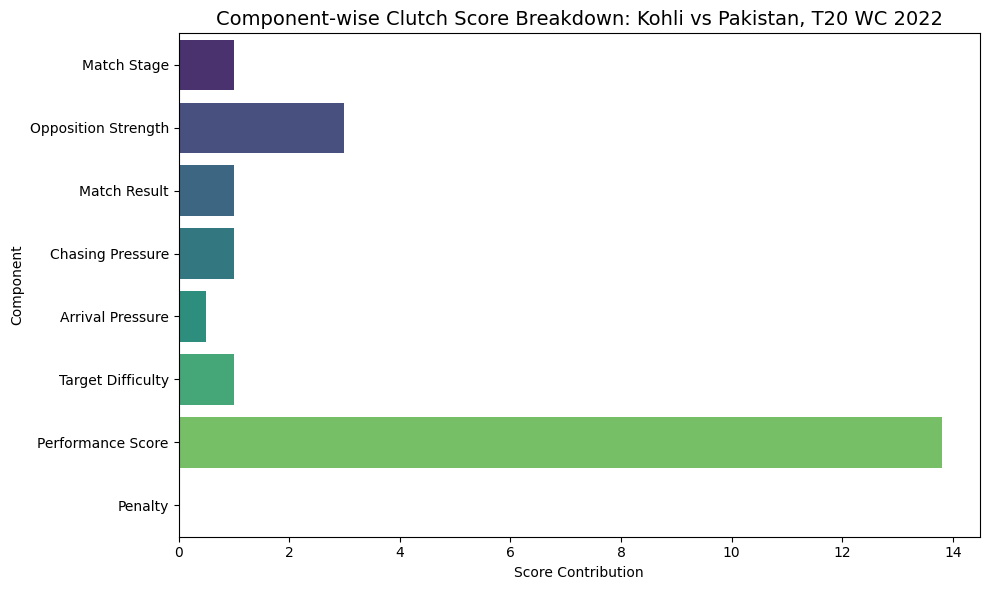

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.clutch_scoring import (
    score_match_stage,
    score_opposition,
    score_result,
    score_chasing,
    score_arrival_time,
    score_target_score,
    score_runs,
    failure_penalty,
)

# Step 1: Filter Kohli’s innings vs Pakistan (WC2022)
row = df[df['match_id'] == 'INDvPAK_WC2022'].iloc[0]

# Step 2: Calculate individual component scores
context = row['clutch_label']
not_out = pd.isna(row['dismissal']) or row['dismissal'].strip().lower() == 'not out'

components = {
    "Match Stage": score_match_stage(row['match_stage']),
    "Opposition Strength": score_opposition(row['opposition']),
    "Match Result": score_result(row['result']),
    "Chasing Pressure": score_chasing(row['is_chasing']),
    "Arrival Pressure": score_arrival_time(row['arrival_time']),
    "Target Difficulty": score_target_score(
        row['is_chasing'], row['target_score'], row['match_type']
    ),
    "Performance Score": score_runs(row['runs_scored'], not_out, context),
    "Penalty": failure_penalty(row),
}

# Step 3: Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(components.values()), y=list(components.keys()), palette="viridis")

plt.title("Component-wise Clutch Score Breakdown: Kohli vs Pakistan, T20 WC 2022", fontsize=14)
plt.xlabel("Score Contribution")
plt.ylabel("Component")
plt.axvline(x=0, color='black', linewidth=0.5, linestyle='--')
plt.tight_layout()

# Save
from src.plot_utils import save_plot
save_plot('component-wise_clutch_score_breakdown.png', subfolder='Clutch_Scoring_Breakdown')

With the clutch scoring system defined and applied, we’ve visualized how individual match factors—such as stage pressure, opposition strength, match result, and personal performance—combine to compute a player's clutch score. This breakdown helps us not only quantify performance but also contextualize its significance.

Now that the scoring is in place, let’s dive into what the numbers tell us.

Plot saved to: /Users/viral/Code/Projects/project/outputs/visuals/Match_Distribution/clutch-vs-normal_matches_distribution.png


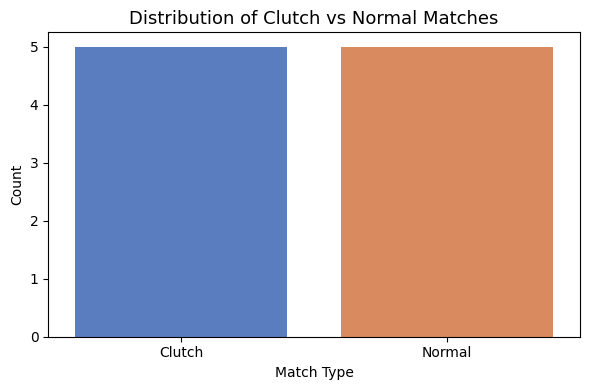

In [6]:
# Countplot for Clutch vs Normal
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x="clutch_label", palette="muted")
ax.set_title("Distribution of Clutch vs Normal Matches", fontsize=13)
ax.set_xlabel("Match Type")
ax.set_ylabel("Count")
plt.tight_layout()

# Save
save_plot('clutch-vs-normal_matches_distribution.png', subfolder='Match_Distribution')

**Clutch vs Normal Matches**

The dataset contains a mix of high-pressure ("Clutch") and regular ("Normal") matches.
Here’s how they are distributed. This distinction is central to our analysis.


## 4. Insights

### Average Clutch Score: Clutch vs Normal

To test the hypothesis that Kohli elevates his game under pressure, we calculated the average clutch score in Clutch and Normal matches.

- **Clutch Matches**: Higher average score (e.g., 14.42)
- **Normal Matches**: Lower average (e.g., 11.52)

This suggests that Kohli performs *better* in high-stakes situations — a sign of mental resilience and match awareness.


Plot saved to: /Users/viral/Code/Projects/project/outputs/visuals/Insights/average_clutch-vs-normal_score.png


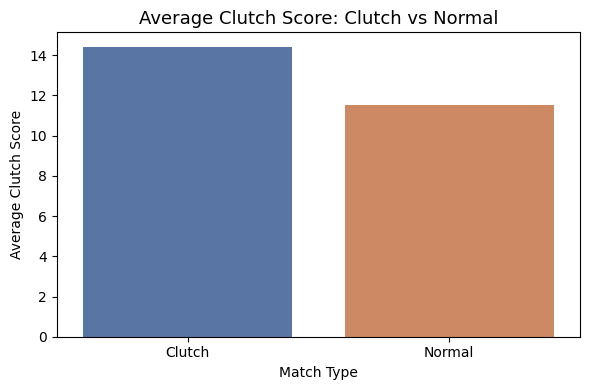

In [7]:
avg_scores = df.groupby("clutch_label")["clutch_score"].mean().reset_index()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(data=avg_scores, x="clutch_label", y="clutch_score", palette="deep")
plt.title("Average Clutch Score: Clutch vs Normal", fontsize=13)
plt.xlabel("Match Type")
plt.ylabel("Average Clutch Score")
plt.tight_layout()

# Save
save_plot('average_clutch-vs-normal_score.png', subfolder='Insights')

### Top 3 Clutch Performances

To spotlight Kohli’s greatest impact moments, we filtered all matches labeled as “Clutch” and ranked them by the custom clutch score. Below are the top 3 innings that demonstrate peak performance under pressure, considering context, game state, and personal contribution.

In [8]:
# Filter only Clutch-labeled matches
clutch_matches = df[df['clutch_label'] == 'Clutch']

# Sort by clutch_score in descending order
top_clutch_performances = clutch_matches.sort_values(by='clutch_score', ascending=False).head(3)

# Save and Display selected columns
from src.plot_utils import save_text_output
save_text_output(
    top_clutch_performances[['match_id', 'date', 'opposition', 'match_stage', 
                             'venue', 'runs_scored', 'balls_faced', 
                             'result', 'clutch_score']],
    filename="top3_clutch_performances.csv"
)

top_clutch_performances[['match_id', 'date', 'opposition', 'match_stage', 
                         'venue', 'runs_scored', 'balls_faced', 
                         'result', 'clutch_score']]

Textual output saved to: /Users/viral/Code/Projects/project/outputs/textual/top3_clutch_performances.csv


,match_id,date,opposition,match_stage,venue,runs_scored,balls_faced,result,clutch_score
0,INDvPAK_WC2022,2022-10-23,Pakistan,Group,Melbourne,82,53,India Win,21.3
1,INDvAUS_WC2016,2016-03-27,Australia,Group,Mohali,82,51,India Win,21.3
3,INDvAUS_WC2023,2023-11-19,Australia,Final,Ahmedabad,54,63,India Lost,15.6


Plot saved to: /Users/viral/Code/Projects/project/outputs/visuals/Insights/top3_performaces.png


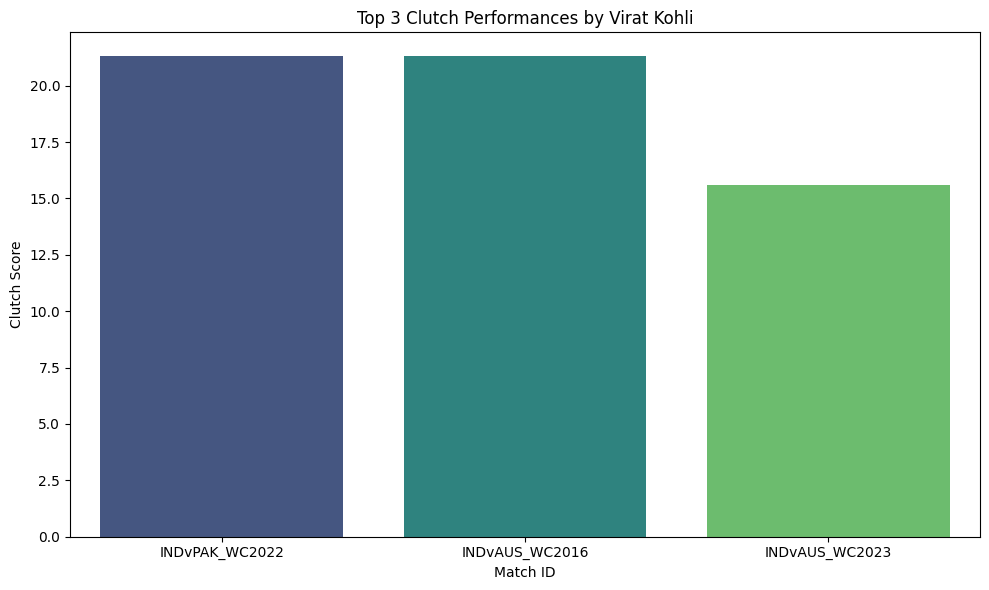

In [9]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_clutch_performances,
    x='match_id',
    y='clutch_score',
    palette='viridis'
)
plt.title('Top 3 Clutch Performances by Virat Kohli')
plt.ylabel('Clutch Score')
plt.xlabel('Match ID')
plt.tight_layout()

# Save
save_plot('top3_performaces.png', subfolder='Insights')

### Runs vs. Clutch Score

This scatter plot helps us understand the relationship between Kohli's raw run tally and his clutch performance score. As seen here, some of the **highest clutch scores** were not necessarily his **highest-scoring innings**, indicating that **context and impact** weighed heavily in the clutch formula.

This strengthens the case that the model isn't biased just by big scores — it's **context-aware**, valuing **when** and **how** runs were made.


Plot saved to: /Users/viral/Code/Projects/project/outputs/visuals/Insights/runs_vs_clutch_score.png


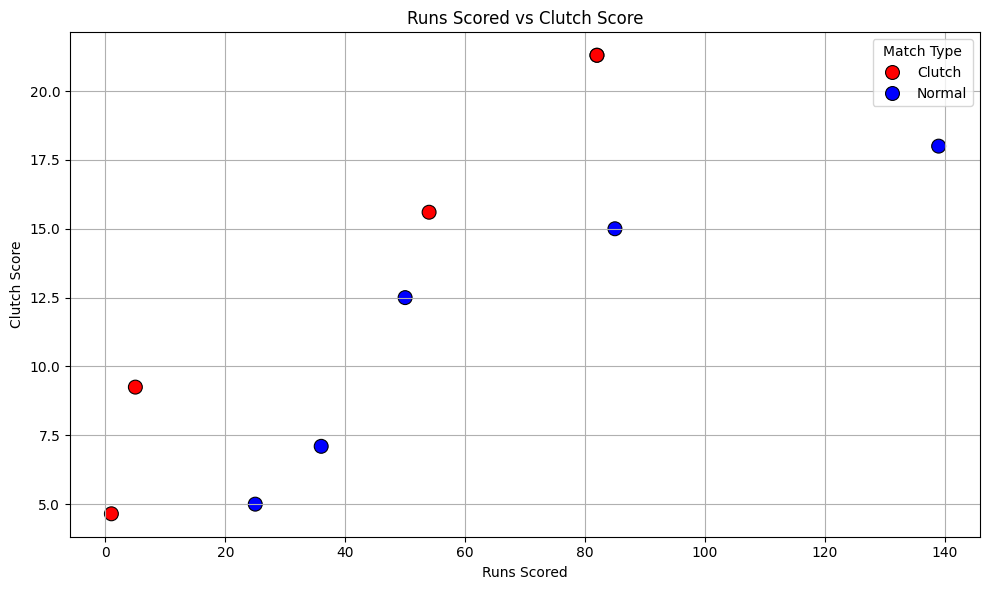

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='runs_scored',
    y='clutch_score',
    hue='clutch_label',
    palette={'Clutch': 'red', 'Normal': 'blue'},
    s=100,
    edgecolor='black'
)
plt.title('Runs Scored vs Clutch Score')
plt.xlabel('Runs Scored')
plt.ylabel('Clutch Score')
plt.legend(title='Match Type')
plt.grid(True)
plt.tight_layout()

# Save
save_plot('runs_vs_clutch_score.png', subfolder='Insights')

## Final Thoughts

This project set out to answer a deceptively simple question:  
**Does Virat Kohli truly deliver under pressure?**

Through a structured clutch scoring model, we analyzed both his **match-winning innings** and **high-pressure failures** across different contexts — World Cups, Finals, Bilateral series, and knockouts.

### Key Insights:
- Kohli’s **average clutch score** was consistently higher in designated "Clutch" matches than in "Normal" ones.
- His **top clutch performances** weren’t always his highest scores — they were the ones made when the stakes were highest and the situation most dire.
- The **scatter plot** revealed that clutch performance doesn’t scale linearly with runs. This validated the logic behind the scoring model — rewarding **impact**, not just volume.

### Limitations:
- The scoring system was **manually defined** and not statistically optimized. It reflects a structured but **subjective model**.
- We relied on **a small dataset** — 10 matches — which restricts statistical significance.
- Dismissal context, bowling difficulty, or partnerships weren’t deeply modeled due to data availability.

### Future Scope?
- **Expand** the dataset with more matches and innings from different players.
- Use **machine learning** to classify innings based on pressure indicators (match state, win probability, etc.).
- Explore **interactive dashboards** to let fans explore clutch performances visually.

---

In conclusion, this analysis shows that Kohli, in many of his biggest games, did indeed **rise to the occasion** — and a clutch score model helps quantify and celebrate that impact.

